# Analyzing neuropil signals in the mice 
* 10/9/23 setup
* 10/16/23 migrating to `sleep` repo and stripping of sima stuff

In [1]:
import sys, os
import matplotlib.pyplot as plt
import itertools

import pandas as pd
import numpy as np
import scipy as sp
import scipy.fft as fft
import scipy.signal as signal

sys.path.append('/home/gergely/code/sleep/base/')

from suite2p_class import Suite2p
from mouse_class import Mouse
from eeg_class import eegData
from behavior_class import behaviorData
# import pandas_bokeh
# pandas_bokeh.output_notebook()

# from bokeh.io import output_file, show
# from bokeh.plotting import figure
# from bokeh.models import LinearAxis, Range1d

# from bokeh.layouts import column
# from bokeh.models import (CustomJS, LinearAxis, Range1d, Select,
#                           WheelZoomTool, ZoomInTool, ZoomOutTool)
# from bokeh.plotting import figure, show


In [2]:
mice  =[
    '5HT2afl05b_1', 
    '5HT2afl05b_1',
    'sert52b_1',
    'sert52b_5',
    'sert54a_5'
    ]


In [3]:
mouse = Mouse(mice[0])
folders = mouse.find_tseries_folders(mouse.root_folder)

In [4]:
s2p_mouse = Suite2p(mouse_id='sert52b_1')
s2p_folders = s2p_mouse.s2p_folders
s2p_folders

['/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima/suite2p',
 '/data2/gergely/invivo_DATA/sleep/sert52b_1/4_4/TSeries-04042023-1023_sess2-002/TSeries-04042023-1023_sess2-002.sima/suite2p']

In [5]:
sima_folder = os.path.dirname(s2p_folders[0])
sima_folder

'/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima'

In [10]:
eeg = eegData(sima_folder=sima_folder)
eeg.eeg_folder
eeg_velo = eeg.load_processed_velocity_eeg
eeg_velo

,Frames,filtered velo,score,awake,NREM,REM,other
0,0,0.0,0,True,False,False,False
1,1,0.0,0,True,False,False,False
2,2,0.0,0,True,False,False,False
3,3,0.0,0,True,False,False,False
4,4,0.0,0,True,False,False,False
...,...,...,...,...,...,...,...
24750,24750,0.0,0,True,False,False,False
24751,24751,0.0,0,True,False,False,False
24752,24752,0.0,0,True,False,False,False
24753,24753,0.0,0,True,False,False,False


In [7]:
behData = behaviorData(sima_folder=sima_folder)
beh_folder = behData.behavior_folder

In [8]:
df = behData.processed_velocity
filt_velo = df['filtered velo']

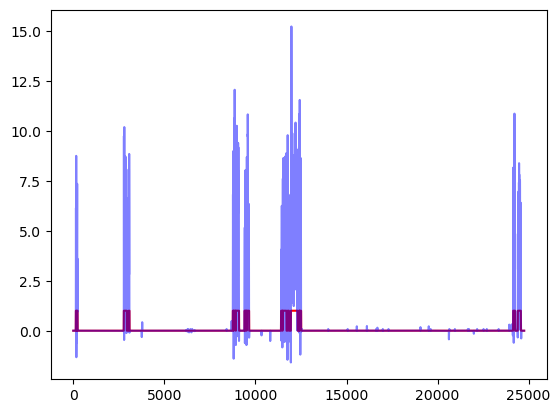

In [9]:
immob = behData.define_immobility(filt_velo)
plt.plot(immob,color='r')
plt.plot(filt_velo,color='b', alpha=0.5)

In [ ]:
cells = s2p_mouse.true_cells(s2p_folders[0])
cells

In [ ]:
def mean_npil(npil_file: str, csv_file: str) -> pd.DataFrame:
    neuropil_signal = np.load(npil_file)
    eeg_signal = pd.read_csv(csv_file)
    nrem_signal = eeg_signal['NREM'].astype(int)
    npil_eeg = pd.DataFrame({'NREM': nrem_signal,
                        'npil':neuropil_signal.mean(axis=0)})
    return npil_eeg

In [ ]:
mice = {'5HT2afl05b_1': [747, 745, 740, 749],
        '5HT2afl05b_2': [762, 761, 760]}
trials = []
for mouse in mice:
    trials.extend(mice[mouse])

sima_paths = []
for trial in trials:
    sima_paths.append(ImagingExperiment(trial).sima_path)

In [ ]:
npil_files = []
for path in sima_paths:
    for r, d, f in os.walk(path):
        for file in f:
            if 'Fneu.npy' in file:
                npil_files.append(os.path.join(r,file))
            
brain_states = []
for path in sima_paths:
    for r, d, f in os.walk(path):
        for file in f:
            if 'velo_eeg.csv' in file:
                brain_states.append(os.path.join(r,file))
len(npil_files)

In [ ]:
npil_means = []
for npil, state in zip(npil_files, brain_states):
    npil_means.append(mean_npil(npil, state))

freqs = []
for df in npil_means:
    freqs.append(freq_calc(df))

In [ ]:
nrem_signal = []
awake_signal = []
for mean in npil_means:
    nrem = mean[mean['NREM'] == 1]['npil'].values
    awake = mean[mean['NREM'] == 0]['npil'].values
    nrem_signal.append(nrem)
    awake_signal.append(awake[:len(nrem)])
# for nrem, awake in zip(nrem_signal, awake_signal):
plt.figure(figsize=(15,5))
plt.plot(nrem_signal[6], color='red')
plt.plot(awake_signal[6], color='blue')


In [ ]:
def freq_calc(data: pd.DataFrame):
    """data: npil_eeg data"""
    nrem = data[data['NREM'] == 1]['npil'].values
    awake = data[data['NREM'] == 0]['npil'].values
    frequencies_nrem, psd_nrem = signal.welch(nrem,
                                          fs=10)
    frequencies_awake, psd_awake = signal.welch(awake[:len(nrem)],
                                          fs=10)
    return frequencies_nrem, psd_nrem, frequencies_awake, psd_awake
#     plt.semilogy(frequencies_nrem, psd_nrem, label='NREM')
#     plt.semilogy(frequencies_awake, psd_awake, label='Awake')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power/Frequency (dB/Hz)')
#     plt.title('Power Spectral Density (Low Frequencies)')
#     plt.legend()
#     plt.grid()
#     plt.show()
    
    

In [ ]:
nrem_f = []
awake_f =[]
for mean in npil_means:
    _, p_nrem, _, p_awake = freq_calc(mean)
    nrem_f.append(p_nrem)
    awake_f.append(p_awake)
nrem_mean = np.mean(nrem_f, axis=0)
awake_mean = np.mean(awake_f, axis=0)
x= np.linspace(0, 5, num=len(nrem_mean))
plt.semilogy(x, nrem_mean, label='NREM')
plt.semilogy(x, awake_mean, label='Awake')
plt.title('Power Spectral Density')  # Customize the title if needed
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()

In [ ]:
figure, axs = plt.subplots(ncols=3, nrows=3, sharex=True, 
                          figsize=(15,15))

# Loop through the subplots and DataFrames in parallel
for ax, df in zip(axs.flat, itertools.islice(npil_means, 9)):
    if df is not None:
        # Calculate the frequencies and PSD using freq_calc
        f_nrem, p_nrem, f_awake, p_awake= freq_calc(df)

        # Plot the data on the current subplot (ax)
        ax.semilogy([0,1], p_nrem, label='NREM')
        ax.semilogy([0,1], p_awake, label='Awake')
        ax.set_title('Power Spectral Density')  # Customize the title if needed
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power/Frequency (dB/Hz)')
        ax.legend()
    else:
        # If there are no more DataFrames, hide the subplot
        ax.axis('off')

# Adjust layout to prevent overlapping titles and labels
figure.tight_layout()

# Show the plot
plt.show()

In [ ]:
neuropil_signal = np.load(npil_files[0])
eeg_signal = pd.read_csv(brain_states[0])
nrem_signal = eeg_signal['NREM'].astype(int)
npil_eeg = pd.DataFrame({'NREM': nrem_signal,
                        'npil':neuropil_signal.mean(axis=0)})
npil_eeg

In [ ]:
x = npil_eeg.index
y1 = npil_eeg['npil']
y2 = npil_eeg['NREM']

p = figure()
p.line(x, y1)
p.axis.axis_label = 'npil'

p.extra_x_ranges['NREM'] = Range1d(x.start, x.stop)
p.extra_y_ranges['NREM'] = Range1d(0,1)

nrem = p.line(x,y2, color='red',x_range_name='NREM',
                y_range_name='NREM')

ax2 = LinearAxis(axis_label='nrem',
                x_range_name='NREM',
                y_range_name='NREM')

ax2.axis_label_text_color = 'red'
p.add_layout(ax2, 'left')

ax3 = LinearAxis(axis_label='nrem')
p.add_layout(ax3, 'below')

wheel_zoom = WheelZoomTool()
p.add_tools(wheel_zoom)
p.toolbar.active_scroll = wheel_zoom
select = Select(title="Zoom together:",
                options=["none", "cross", "all"],
                )

show(p)

In [ ]:
nrem = npil_eeg[npil_eeg['NREM']==1]['npil'].values
awake = npil_eeg[npil_eeg['NREM']==0]['npil'].values
nrem

In [ ]:
low_freq = 0.0
high_freq = 15.0

frequencies_nrem, psd_nrem = signal.welch(nrem,
                                          fs=10)
frequencies_awake, psd_awake = signal.welch(awake[:len(nrem)],
                                          fs=10)
low_idx_nrem = np.where(frequencies_nrem >= low_freq)[0][0]
high_idx_nrem = np.where(frequencies_nrem <= high_freq)[0][-1]

low_idx_awake = np.where(frequencies_awake >= low_freq)[0][0]
high_idx_awake = np.where(frequencies_awake <= high_freq)[0][-1]
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_nrem[low_idx_nrem:high_idx_nrem], 
             psd_nrem[low_idx_nrem:high_idx_nrem], label='NREM')
plt.semilogy(frequencies_awake[low_idx_awake:high_idx_awake], 
             psd_awake[low_idx_awake:high_idx_awake], label='Awake')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (Low Frequencies)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Define parameters for STFT
window_length = 100  # Length of the window in samples (adjust as needed)
overlap = 50  # Number of samples to overlap between consecutive windows (adjust as needed)

# Compute STFT for 'nrem' signal
frequencies_nrem, times_nrem, Sxx_nrem = signal.spectrogram(nrem, fs=10,
                                                           window='hann', nperseg=window_length,
                                                           noverlap=overlap)

# Compute STFT for 'awake' signal
frequencies_awake, times_awake, Sxx_awake = signal.spectrogram(awake[:len(nrem)], fs=10,
                                                               window='hann', nperseg=window_length,
                                                               noverlap=overlap)


In [ ]:
# Plot the spectrogram for 'nrem' signal
plt.figure(figsize=(10, 6))
plt.imshow(10 * np.log10(Sxx_nrem), aspect='auto', cmap='viridis', origin='lower',
           extent=[times_nrem.min(), times_nrem.max(), frequencies_nrem.min(), frequencies_nrem.max()])
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram (NREM)')
plt.show()

# Plot the spectrogram for 'awake' signal
plt.figure(figsize=(10, 6))
plt.imshow(10 * np.log10(Sxx_awake), aspect='auto', cmap='viridis', origin='lower',
           extent=[times_awake.min(), times_awake.max(), frequencies_awake.min(), frequencies_awake.max()])
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram (Awake)')
plt.show()
